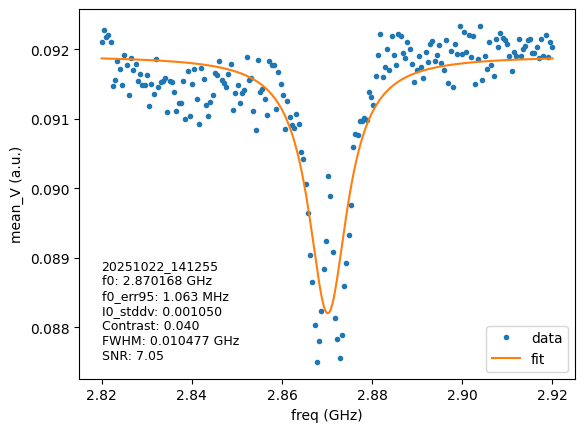


=== NV Temperature analysis ===
f_meas - f_theory = 0.168 MHz
ΔT = -2.26 K → T_NV = 297.74 K
{'f0_GHz': 2.8701677766510496, 'f0_err95_MHz': np.float64(1.0632288821483589), 'I0': 0.0919061905187583, 'I0_stddv': 0.0010498088768100696, 'Contrast': 0.04027699028928033, 'FWHM_GHz': 0.010477414966905034, 'SNR': 7.052149824255077}


In [18]:
# -*- coding: utf-8 -*-
"""
Robust ODMR single-Lorentz fit with parameter analysis & CSV export
- Reads CSV with columns: freq_Hz, mean_V, [std_V]
- Safe preprocessing (NaN/Inf removal, sorting)
- Frequency in GHz (model), HWHM in MHz (parameters)
- Bounds + larger maxfev for stable convergence
- Outputs: PNG + *_params.csv + *_data.csv + *_fit1.csv
"""

from pathlib import Path
import os, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ========= User paths & filenames =========
BASE = Path(r"C:\Users\Bridgman\Desktop\Ohkuma\Data")   # <- change if needed
NAME = "20251022_141255"                                 # input CSV w/o .csv
OUTDIR = BASE / "processed_fit1"
OUTDIR.mkdir(parents=True, exist_ok=True)

# ========= Model: x in GHz, hwhm in MHz =========
def lorentz_1(x_GHz, x0_GHz, a_depth, hwhm_MHz, offset):
    hw_GHz = hwhm_MHz * 1e-3
    return offset - a_depth * hw_GHz**2 / (hw_GHz**2 + (x_GHz - x0_GHz)**2)

# ========= Load & prepare =========
def load_odmr_csv(path: Path):
    # auto-detect delimiter; accept headers
    df = pd.read_csv(path, sep=None, engine="python")
    # basic column sanity
    required = ["freq_Hz", "mean_V"]
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found. Columns: {list(df.columns)}")
    # numeric, finite, sorted by freq
    f_hz = pd.to_numeric(df["freq_Hz"], errors="coerce")
    y    = pd.to_numeric(df["mean_V"], errors="coerce")
    w    = pd.to_numeric(df["std_V"], errors="coerce") if "std_V" in df.columns else None

    m = np.isfinite(f_hz) & np.isfinite(y)
    if w is not None:
        m = m & np.isfinite(w)

    f_hz, y = f_hz[m].to_numpy(), y[m].to_numpy()
    w = w[m].to_numpy() if w is not None else None

    idx = np.argsort(f_hz)
    f_hz, y = f_hz[idx], y[idx]
    if w is not None:
        w = w[idx]
    return f_hz, y, w

def robust_init(x_hz: np.ndarray, y: np.ndarray):
    x = x_hz / 1e9  # to GHz
    n = len(x)
    k = max(1, n // 10)
    baseline = float(np.median(np.r_[y[:k], y[-k:]]))  # outer 10% as baseline
    i_min = int(np.argmin(y))
    x0 = float(x[i_min])
    a0 = max(1e-6, baseline - float(np.min(y)))  # depth (>0)
    hwhm0_mhz = 10.0                             # plausible initial width (MHz)
    return x, baseline, x0, a0, hwhm0_mhz

# ========= Fit & analyze =========
def fit_and_export(name: str):
    # 1) load
    csv_path = BASE / f"{name}.csv"
    x_hz, y, std = load_odmr_csv(csv_path)
    x, off0, x0, a0, hwhm0 = robust_init(x_hz, y)

    # 2) fit (optional weighting if std_V available)
    bounds = ([x.min(), 0.0, 0.1, y.min()],
              [x.max(), 2.0*(y.max()-y.min()) + 1e-6, 100., y.max()])
    p0 = [x0, a0, hwhm0, off0]

    kwargs = dict(p0=p0, bounds=bounds, method="trf", maxfev=20000)
    if std is not None and np.all(std > 0):
        # absolute_sigma=True makes covariance reflect true noise scale
        kwargs.update(dict(sigma=std, absolute_sigma=True))

    popt, pcov = curve_fit(lorentz_1, x, y, **kwargs)
    perr = np.sqrt(np.diag(pcov))

    # 3) smooth curve
    x_fit = np.linspace(x.min(), x.max(), 1200)
    y_fit = lorentz_1(x_fit, *popt)

    # 4) analysis
    f0_GHz   = float(popt[0])
    a_depth  = float(popt[1])
    hwhm_MHz = float(popt[2])
    I0       = float(popt[3])

    Imin     = I0 - a_depth        # valley
    Contrast = (I0 - Imin) / I0 if I0 != 0 else np.nan

    # estimate noise outside resonance (exclude 2.9–3.1 GHz as resonance window)
    left, right = 2.9, 3.1
    mask_bg = ~((x > left) & (x < right))
    I0_stddv = float(np.std(y[mask_bg] - I0)) if mask_bg.any() else float("nan")

    FWHM_GHz = 2.0 * hwhm_MHz * 1e-3
    SNR = (I0 * Contrast / I0_stddv * 2.0) if np.isfinite(I0_stddv) and I0_stddv > 0 else float("nan")
    f0_err95_MHz = 1.96 * perr[0] * 1e3  # 95% CI approx (from covariance)

    # normalized
    y_norm     = y / I0
    y_fit_norm = y_fit / I0

    # 5) plot
    plt.figure()
    plt.plot(x, y, ".", label="data")
    plt.plot(x_fit, y_fit, "-", label="fit")
    txt = (
        f"{name}\n"
        f"f0: {f0_GHz:.6f} GHz\n"
        f"f0_err95: {f0_err95_MHz:.3f} MHz\n"
        f"I0_stddv: {I0_stddv:.6f}\n"
        f"Contrast: {Contrast:.3f}\n"
        f"FWHM: {FWHM_GHz:.6f} GHz\n"
        f"SNR: {SNR:.2f}"
    )
    plt.text(x.min(), y.min(), txt, fontsize=9, va="bottom")
    plt.xlabel("freq (GHz)"); plt.ylabel("mean_V (a.u.)"); plt.legend()
    plt.savefig(OUTDIR / f"{name}.png", dpi=400, bbox_inches="tight")
    plt.show()

    # 6) CSV exports
    # (a) parameters
    params_names  = ["x0_GHz", "a_depth", "hwhm_MHz", "off_baseline"]
    params_values = [f0_GHz, a_depth, hwhm_MHz, I0]
    params_errors = list(perr)
    conf95        = [1.96*e for e in params_errors]
    with open(OUTDIR / f"{name}_params.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["Parameter", "Value", "StdErr", "95%CI(±)"])
        for n, v, e, c in zip(params_names, params_values, params_errors, conf95):
            w.writerow([n, v, e, c])
        w.writerow([])
        w.writerow(["Derived", "Value", "Unit", "Note"])
        w.writerow(["F0", f0_GHz, "GHz", "center frequency"])
        w.writerow(["F0_err95", f0_err95_MHz, "MHz", "approx 1.96σ"])
        w.writerow(["FWHM", FWHM_GHz, "GHz", "2*HWHM"])
        w.writerow(["Contrast", Contrast, "", "(I0 - Imin)/I0"])
        w.writerow(["I0_stddv", I0_stddv, "a.u.", "outside resonance"])
        w.writerow(["SNR", SNR, "", "I0*Contrast/σ * 2"])

    # (b) raw & normalized
    with open(OUTDIR / f"{name}_data.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["freq_GHz", "y", "y_norm"])
        for xi, yi, yni in zip(x, y, y_norm):
            w.writerow([xi, yi, yni])

    # (c) fitted curve
    with open(OUTDIR / f"{name}_fit1.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["freq_GHz", "fit_y", "fit_y_norm"])
        for xi, yi, yni in zip(x_fit, y_fit, y_fit_norm):
            w.writerow([xi, yi, yni])

        # --- NV 温度解析 ---
    f_theory_GHz = 2.870000   # 理論的なゼロ磁場分裂 (常温)
    kT_GHz_per_K = -7.42e-5   # 温度係数 [GHz/K]
    delta_f_GHz  = f0_GHz - f_theory_GHz
    delta_T_K    = delta_f_GHz / kT_GHz_per_K
    T_NV_K       = 300.0 + delta_T_K

    print(f"\n=== NV Temperature analysis ===")
    print(f"f_meas - f_theory = {delta_f_GHz*1e3:.3f} MHz")
    print(f"ΔT = {delta_T_K:.2f} K → T_NV = {T_NV_K:.2f} K")

    # CSVに追加出力
    with open(OUTDIR / f"{name}_params.csv", "a", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow([])
        w.writerow(["NV Temperature Analysis"])
        w.writerow(["f_meas_minus_theory", delta_f_GHz*1e3, "MHz", "frequency shift"])
        w.writerow(["ΔT", delta_T_K, "K", "temperature change"])
        w.writerow(["T_NV", T_NV_K, "K", "absolute temperature"])

    return dict(f0_GHz=f0_GHz, f0_err95_MHz=f0_err95_MHz, I0=I0,
                I0_stddv=I0_stddv, Contrast=Contrast, FWHM_GHz=FWHM_GHz, SNR=SNR)

    

# ===== run =====
results = fit_and_export(NAME)
print(results)




# 2peak fit

f1: 2.867611 GHz,  f2: 2.873033 GHz
f0 (center): 2.870322 GHz   ±0.593 MHz (95%)
FWHM1: 0.003989 GHz,  FWHM2: 0.003577 GHz
Split: 5.42 MHz
I0: 0.09176919,  I0_stddv: 0.001050,  Contrast: 0.0404,  SNR: 7.07
---- Temperature from frequency shift ----
(f_meas - f_theory) = +0.322 MHz  ->  ΔT = -4.35 K,  T_NV = 295.65 K
---- Magnetic field from splitting ----
B_parallel = 0.967 G ± 0.078 G   (0.097 mT ± 0.008 mT,  9.673e-05 T ± 7.830e-06 T)


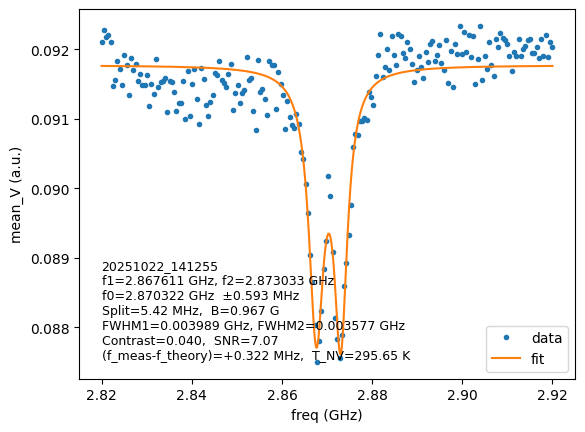

{'f1_GHz': 2.8676114522119343, 'f2_GHz': 2.8730333752953134, 'f0_GHz': 2.870322413753624, 'f0_err95_MHz': np.float64(0.593020418124523), 'FWHM1_GHz': np.float64(0.0039886969718214375), 'FWHM2_GHz': np.float64(0.003576785256894155), 'Split_MHz': 5.421923083379188, 'I0': np.float64(0.09176918800148649), 'I0_stddv': 0.0010498088768100696, 'Contrast': np.float64(0.0404183388110367), 'SNR': np.float64(7.066349342231486), 'delta_f_MHz': 0.3224137536239624, 'T_NV_K': 295.65480116409753, 'B_G': 0.9673385828305113, 'B_err_G': np.float64(0.07829896446230487), 'B_mT': 0.09673385828305114, 'B_T': 9.673385828305114e-05}


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [22]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

BASE = Path(r"C:\Users\Bridgman\Desktop\Ohkuma\Data")
name = "20251022_141255"

def lor_2(x_GHz, x0, a, hwhm_MHz, x02, a2, hwhm2_MHz, off):
    hw1 = hwhm_MHz  * 1e-3  # MHz→GHz# -*- coding: utf-8 -*-
"""
Two-peak ODMR fit (double Lorentz) with full analysis & exports
- CSV columns expected: freq_Hz, mean_V, [std_V]
- Adds: (meas - theory) frequency offset, NV temperature, magnetic field from splitting
"""

from pathlib import Path
import os, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ========= User paths & filenames =========
BASE  = Path(r"C:\Users\Bridgman\Desktop\Ohkuma\Data")
NAME  = "20251022_141255"
OUT   = BASE / "processed_fit2"
OUT.mkdir(parents=True, exist_ok=True)

# ========= Constants =========
GAMMA_E_MHZ_PER_G = 2.802495     # electron gyromagnetic ratio (MHz/G)
F_THEORY_GHZ      = 2.870000     # theoretical zero-field splitting (~300 K)
KT_GHZ_PER_K      = -7.42e-5     # temperature coefficient (GHz/K)
T0_K              = 300.0

# ========= Model: x in GHz, HWHM in MHz =========
def lorentz2(x_GHz, x0, a, hwhm_MHz, x02, a2, hwhm2_MHz, off):
    hw1 = hwhm_MHz  * 1e-3
    hw2 = hwhm2_MHz * 1e-3
    return off - a  * hw1**2 / (hw1**2 + (x_GHz - x0 )**2) \
               - a2 * hw2**2 / (hw2**2 + (x_GHz - x02)**2)

# ========= Load & init =========
def load_csv(path: Path):
    df = pd.read_csv(path, sep=None, engine="python")
    for col in ["freq_Hz", "mean_V"]:
        if col not in df.columns:
            raise ValueError(f"Missing column '{col}'. Found: {list(df.columns)}")
    f_hz = pd.to_numeric(df["freq_Hz"], errors="coerce").to_numpy()
    y    = pd.to_numeric(df["mean_V"], errors="coerce").to_numpy()
    std  = pd.to_numeric(df["std_V"], errors="coerce").to_numpy() if "std_V" in df.columns else None

    m = np.isfinite(f_hz) & np.isfinite(y)
    if std is not None:
        m &= np.isfinite(std)
        std = std[m]
    f_hz, y = f_hz[m], y[m]

    idx = np.argsort(f_hz)
    f_hz, y = f_hz[idx], y[idx]
    if std is not None:
        std = std[idx]
    return f_hz, y, std

def init_params(x_hz: np.ndarray, y: np.ndarray):
    x = x_hz / 1e9  # GHz
    n = len(x)
    k = max(1, n // 10)
    off0 = float(np.median(np.r_[y[:k], y[-k:]]))

    # two lowest points as initial centers
    idx2 = np.argpartition(y, 2)[:2]
    xs = np.sort(x[idx2])
    x01, x02 = float(xs[0]), float(xs[1])

    a0  = max(1e-6, off0 - float(np.min(y)))
    a02 = a0
    h1  = 10.0  # MHz
    h2  = 10.0  # MHz
    return x, [x01, a0, h1, x02, a02, h2, off0]

# ========= Fit & analyze =========
def fit_and_export(name: str):
    # ---- load & init ----
    csv_path = BASE / f"{name}.csv"
    x_hz, y, std = load_csv(csv_path)
    x, p0 = init_params(x_hz, y)

    ymin, ymax = float(np.min(y)), float(np.max(y))
    bounds = (
        [x.min(), 0.0, 0.1, x.min(), 0.0, 0.1, ymin],
        [x.max(), 2.0*(ymax-ymin)+1e-6, 100., x.max(), 2.0*(ymax-ymin)+1e-6, 100., ymax]
    )

    kwargs = dict(p0=p0, bounds=bounds, method="trf", maxfev=20000)
    if std is not None and np.all(std > 0):
        kwargs.update(dict(sigma=std, absolute_sigma=True))

    popt, pcov = curve_fit(lorentz2, x, y, **kwargs)
    perr = np.sqrt(np.diag(pcov))

    # ---- smooth curve ----
    xf = np.linspace(x.min(), x.max(), 1500)
    yf = lorentz2(xf, *popt)

    # ========= Metrics =========
    x0, a, hwhm1_MHz, x02, a2, hwhm2_MHz, I0 = popt
    f1_GHz, f2_GHz = float(x0), float(x02)
    f0_GHz = (f1_GHz + f2_GHz) / 2.0

    # Uncertainty of center (95%CI) from covariance
    var_avg = (perr[0]**2 + perr[3]**2 + 2.0*pcov[0,3]) / 4.0
    f0_err95_MHz = 1.96 * np.sqrt(var_avg) * 1e3

    # Background noise outside resonance window
    left, right = 2.9, 3.1
    mask_bg = ~((x > left) & (x < right))
    I0_stddv = float(np.std(y[mask_bg] - I0)) if mask_bg.any() else float("nan")

    # Contrast (use deeper branch depth)
    Imin_est = I0 - max(a, a2)
    Contrast = (I0 - Imin_est) / I0 if I0 != 0 else float("nan")

    FWHM1_GHz = 2.0 * hwhm1_MHz * 1e-3
    FWHM2_GHz = 2.0 * hwhm2_MHz * 1e-3
    Split_MHz = (f2_GHz - f1_GHz) * 1e3
    SNR = (I0 * Contrast / I0_stddv * 2.0) if np.isfinite(I0_stddv) and I0_stddv > 0 else float("nan")

    # ========= Temperature from frequency offset =========
    delta_f_GHz  = f0_GHz - F_THEORY_GHZ
    delta_T_K    = delta_f_GHz / KT_GHZ_PER_K
    T_NV_K       = T0_K + float(delta_T_K)

    # ========= Magnetic field from splitting =========
    # Split uncertainty from covariance: Var(f2 - f1) = Var(f2)+Var(f1)-2Cov(f1,f2)
    # perr[...] are std devs of parameters; pcov[...] is covariance.
    sigma_split_MHz = 1e3 * np.sqrt(perr[3]**2 + perr[0]**2 - 2.0*pcov[0,3])

    B_G   = Split_MHz / (2.0 * GAMMA_E_MHZ_PER_G)               # in Gauss
    B_mT  = 0.1 * B_G                                           # 1 G = 0.1 mT
    B_T   = B_G * 1e-4                                          # 1 G = 1e-4 T
    B_err_G  = sigma_split_MHz / (2.0 * GAMMA_E_MHZ_PER_G)
    B_err_mT = 0.1 * B_err_G
    B_err_T  = 1e-4 * B_err_G

    # ---- prints ----
    print(f"f1: {f1_GHz:.6f} GHz,  f2: {f2_GHz:.6f} GHz")
    print(f"f0 (center): {f0_GHz:.6f} GHz   ±{f0_err95_MHz:.3f} MHz (95%)")
    print(f"FWHM1: {FWHM1_GHz:.6f} GHz,  FWHM2: {FWHM2_GHz:.6f} GHz")
    print(f"Split: {Split_MHz:.2f} MHz")
    print(f"I0: {I0:.8f},  I0_stddv: {I0_stddv:.6f},  Contrast: {Contrast:.4f},  SNR: {SNR:.2f}")
    print("---- Temperature from frequency shift ----")
    print(f"(f_meas - f_theory) = {delta_f_GHz*1e3:+.3f} MHz  ->  ΔT = {delta_T_K:.2f} K,  T_NV = {T_NV_K:.2f} K")
    print("---- Magnetic field from splitting ----")
    print(f"B_parallel = {B_G:.3f} G ± {B_err_G:.3f} G   ({B_mT:.3f} mT ± {B_err_mT:.3f} mT,  {B_T:.3e} T ± {B_err_T:.3e} T)")

    # ---- plot ----
    plt.figure()
    plt.plot(x, y, ".", label="data")
    plt.plot(xf, yf, "-", label="fit")
    txt = (f"{NAME}\n"
           f"f1={f1_GHz:.6f} GHz, f2={f2_GHz:.6f} GHz\n"
           f"f0={f0_GHz:.6f} GHz  ±{f0_err95_MHz:.3f} MHz\n"
           f"Split={Split_MHz:.2f} MHz,  B={B_G:.3f} G\n"
           f"FWHM1={FWHM1_GHz:.6f} GHz, FWHM2={FWHM2_GHz:.6f} GHz\n"
           f"Contrast={Contrast:.3f},  SNR={SNR:.2f}\n"
           f"(f_meas-f_theory)={delta_f_GHz*1e3:+.3f} MHz,  T_NV={T_NV_K:.2f} K")
    plt.text(x.min(), y.min(), txt, fontsize=9, va="bottom")
    plt.xlabel("freq (GHz)"); plt.ylabel("mean_V (a.u.)"); plt.legend()
    plt.savefig(OUT / f"{NAME}.png", dpi=450, bbox_inches="tight")
    plt.show()

    # ---- exports ----
    with open(OUT / f"{NAME}_params2.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["Parameter", "Value", "Unit", "Note"])
        w.writerow(["f1", f1_GHz, "GHz", "lower branch center"])
        w.writerow(["f2", f2_GHz, "GHz", "upper branch center"])
        w.writerow(["f0", f0_GHz, "GHz", "center = (f1+f2)/2"])
        w.writerow(["f0_err95", f0_err95_MHz, "MHz", "95% CI from covariance"])
        w.writerow(["FWHM1", FWHM1_GHz, "GHz", "2*HWHM1"])
        w.writerow(["FWHM2", FWHM2_GHz, "GHz", "2*HWHM2"])
        w.writerow(["Split", Split_MHz, "MHz", "f2 - f1"])
        w.writerow(["I0", I0, "a.u.", "baseline (offset)"])
        w.writerow(["I0_stddv", I0_stddv, "a.u.", "std outside resonance"])
        w.writerow(["Contrast", Contrast, "", "(I0 - Imin)/I0"])
        w.writerow(["SNR", SNR, "", "I0*Contrast/σ * 2"])
        w.writerow([])
        w.writerow(["NV Temperature Analysis"])
        w.writerow(["f_meas_minus_theory", delta_f_GHz*1e3, "MHz", "f0 - 2.870 GHz"])
        w.writerow(["ΔT", float(delta_T_K), "K", "Δf / (-74.2 kHz/K)"])
        w.writerow(["T_NV", T_NV_K, "K", "300 K + ΔT"])
        w.writerow([])
        w.writerow(["Magnetic Field from Splitting"])
        w.writerow(["B_parallel", B_G, "G", "Split/(2*γ_e)"])
        w.writerow(["B_parallel_err", B_err_G, "G", "propagated from σ_Split"])
        w.writerow(["B_parallel_mT", B_mT, "mT", "1 G = 0.1 mT"])
        w.writerow(["B_parallel_T", B_T, "T", "1 G = 1e-4 T"])

    # raw & normalized
    y_norm = y / I0
    with open(OUT / f"{NAME}_data.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["freq_GHz", "y", "y_norm"])
        for xi, yi, yni in zip(x, y, y_norm):
            w.writerow([xi, yi, yni])

    # fitted curve
    yfit_norm = yf / I0
    with open(OUT / f"{NAME}_fit2.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["freq_GHz", "fit_y", "fit_y_norm"])
        for xi, yi, yni in zip(xf, yf, yfit_norm):
            w.writerow([xi, yi, yni])

    return dict(
        f1_GHz=f1_GHz, f2_GHz=f2_GHz, f0_GHz=f0_GHz, f0_err95_MHz=f0_err95_MHz,
        FWHM1_GHz=FWHM1_GHz, FWHM2_GHz=FWHM2_GHz, Split_MHz=Split_MHz,
        I0=I0, I0_stddv=I0_stddv, Contrast=Contrast, SNR=SNR,
        delta_f_MHz=delta_f_GHz*1e3, T_NV_K=T_NV_K,
        B_G=B_G, B_err_G=B_err_G, B_mT=B_mT, B_T=B_T
    )

# ===== run =====
res = fit_and_export(NAME)
print(res)

#    hw2 = hwhm2_MHz * 1e-3
#    return off - a  * hw1**2 / (hw1**2 + (x_GHz - x0 )**2) \
#               - a2 * hw2**2 / (hw2**2 + (x_GHz - x02)**2)

# --- load & prepare ---
df = pd.read_csv(BASE / f"{name}.csv", sep=None, engine="python").sort_values("freq_Hz")
x_GHz = df["freq_Hz"].to_numpy(float) / 1e9
y     = df["mean_V"].to_numpy(float)

# 初期値と境界
off0  = float(np.median(np.r_[y[:20], y[-20:]]))
i_min = int(np.argmin(y))
x0_1  = float(x_GHz[i_min]) - 0.002   # ざっくり左右に分ける
x0_2  = float(x_GHz[i_min]) + 0.002
a0, a02 = max(1e-6, off0 - y.min()), max(1e-6, off0 - y.min())
p0 = [x0_1, a0, 10.0, x0_2, a02, 10.0, off0]  # hwhm=10 MHz 初期
bounds = ([x_GHz.min(), 0.0, 0.1, x_GHz.min(), 0.0, 0.1, y.min()],
          [x_GHz.max(), 2*(y.max()-y.min()), 100., x_GHz.max(), 2*(y.max()-y.min()), 100., y.max()])

popt, pcov = curve_fit(lor_2, x_GHz, y, p0=p0, bounds=bounds, method="trf", maxfev=20000)
perr = np.sqrt(np.diag(pcov))

# --- analysis (あなたの指標に対応) ---
x0, a, hw1, x02, a2, hw2, I0 = popt
f1, f2 = x0, x02
f0 = (f1 + f2) / 2
f0_err95_MHz = 1.96 * 1e3 * np.sqrt(perr[0]**2 + perr[3]**2 + 2*pcov[0,3]) / 2
I1 = I0 - a2            # 2峰目の深さを採用（必要なら a と a2 の選択を調整）
Cont = (I0 - I1) / I0
FWHM_GHz = 2*hw1*1e-3   # 片側だけ出したいなら hw1 を使用
SNR = np.nan            # 背景σは別途ROIで計算可（以前の式を流用）

# --- plot ---
xf = np.linspace(x_GHz.min(), x_GHz.max(), 1200)
yf = lor_2(xf, *popt)
plt.figure()
plt.plot(x_GHz, y, ".", label="data")
plt.plot(xf, yf, "-", label="fit")
plt.xlabel("freq (GHz)"); plt.ylabel("mean_V"); plt.legend(); plt.show()
